In [1]:
import numpy as np
import pandas as pd
path = '/Users/khoavan/Downloads/dow_jones_data_clean.csv'
df = pd.read_csv(path)
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Ticker
0,1980-12-12 00:00:00+00:00,0.098943,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1,1980-12-15 00:00:00+00:00,0.093781,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
2,1980-12-16 00:00:00+00:00,0.086898,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
3,1980-12-17 00:00:00+00:00,0.089049,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
4,1980-12-18 00:00:00+00:00,0.091630,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


In [3]:
df.isnull().sum()


Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
Ticker       0
dtype: int64

1. Data analysis


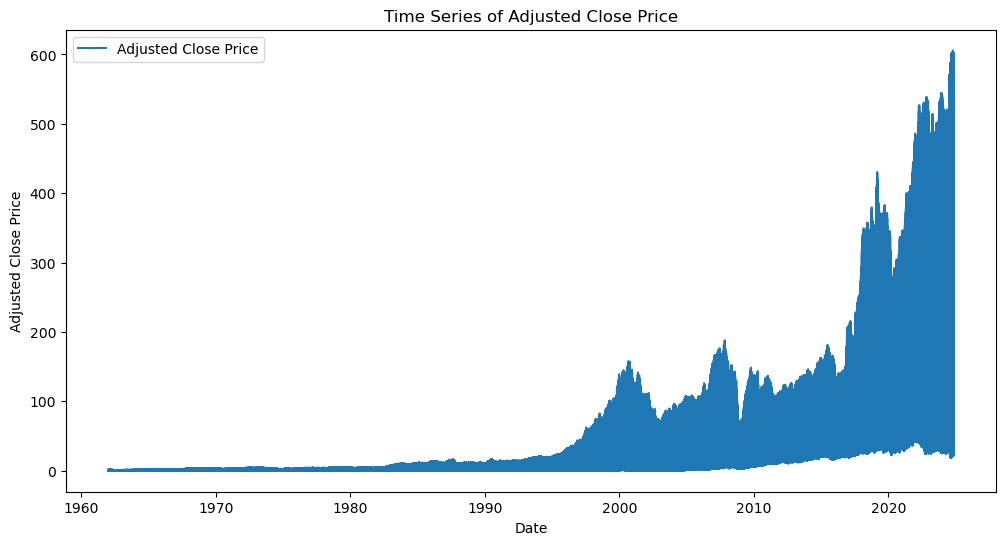

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df.set_index('Date', inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(df['Adj Close'], label='Adjusted Close Price')
plt.title('Time Series of Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

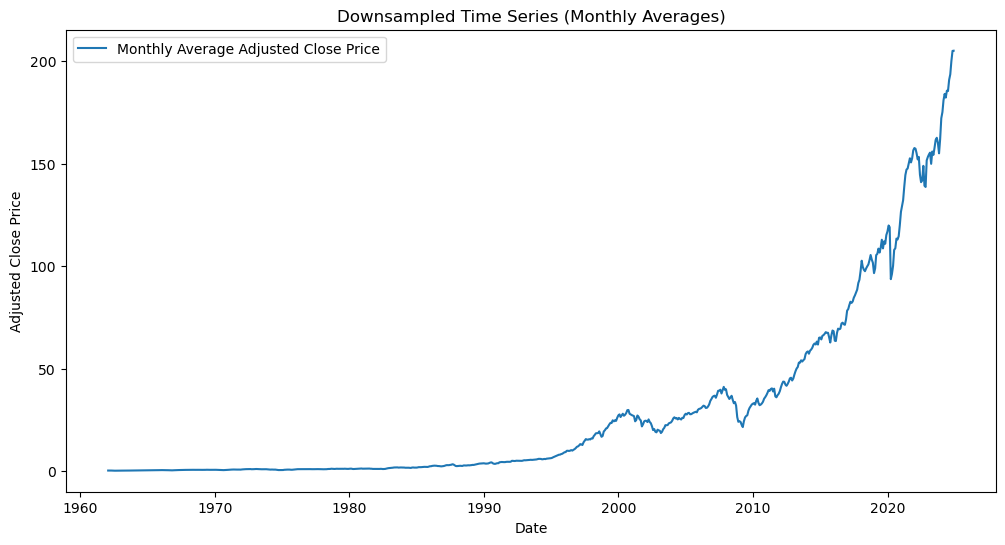

In [ ]:
monthly_data = df['Adj Close'].resample('M').mean()
plt.figure(figsize=(12, 6))
plt.plot(monthly_data, label='Monthly Average Adjusted Close Price')
plt.title('Downsampled Time Series (Monthly Averages)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

In [6]:
adf_test_downsampled = adfuller(monthly_data.dropna())
adf_result_downsampled = {
    "ADF Statistic": adf_test_downsampled[0],
    "p-value": adf_test_downsampled[1],
    "Critical Values": adf_test_downsampled[4]
}
adf_result_downsampled

{'ADF Statistic': 6.281312555074674,
 'p-value': 1.0,
 'Critical Values': {'1%': -3.439290485895927,
  '5%': -2.8654856985173414,
  '10%': -2.568871126669587}}

Since p > 0.05 and ADF statistic is greater than the critical values, we can't reject null hypothesis.

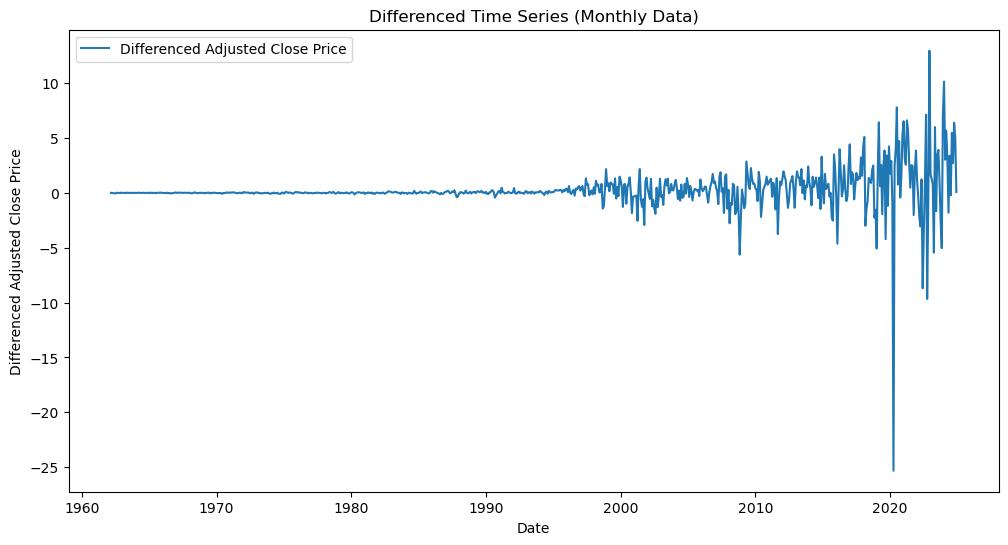

In [7]:
differenced_data = monthly_data.diff().dropna()
plt.figure(figsize=(12, 6))
plt.plot(differenced_data, label='Differenced Adjusted Close Price')
plt.title('Differenced Time Series (Monthly Data)')
plt.xlabel('Date')
plt.ylabel('Differenced Adjusted Close Price')
plt.legend()
plt.show()


In [8]:
adf_test_differenced = adfuller(differenced_data)
adf_result_differenced = {
    "ADF Statistic": adf_test_differenced[0],
    "p-value": adf_test_differenced[1],
    "Critical Values": adf_test_differenced[4]
}
adf_result_differenced

{'ADF Statistic': -4.680991027026953,
 'p-value': 9.135115824981965e-05,
 'Critical Values': {'1%': -3.4392418578608983,
  '5%': -2.86546426916434,
  '10%': -2.568859710342903}}

We reject the null hypothesis, hence stationary.

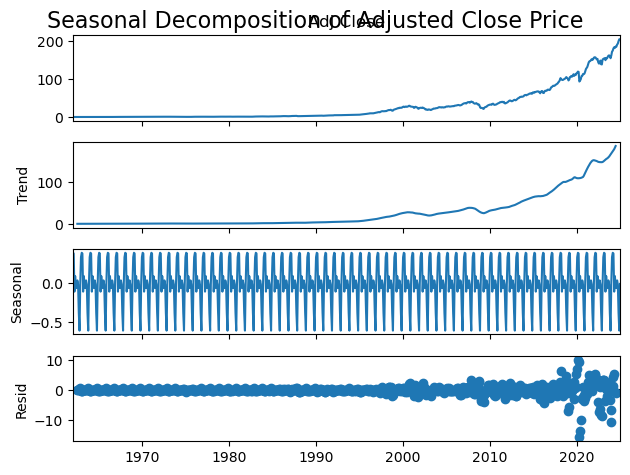

<Figure size 1000x600 with 0 Axes>

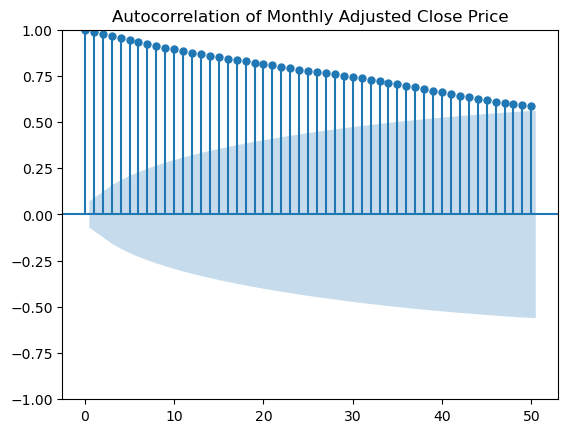

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Decompose the time series (monthly data)
decomposition = seasonal_decompose(monthly_data, model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Adjusted Close Price', fontsize=16)
plt.show()

# Plot the ACF to check for seasonality
plt.figure(figsize=(10, 6))
plot_acf(monthly_data, lags=50, title='Autocorrelation of Monthly Adjusted Close Price')
plt.show()


2. ARIMA

In [13]:
split_index = int(len(differenced_data) * 0.8)
train_data = differenced_data[:split_index]
test_data = differenced_data[split_index:]


In [14]:
from statsmodels.tsa.arima.model import ARIMA
p, d, q = 1, 1, 1
arima_model = ARIMA(train_data, order=(p, d, q))
fitted_arima_model = arima_model.fit()
fitted_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  603
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -573.685
Date:                Sun, 01 Dec 2024   AIC                           1153.369
Time:                        05:12:00   BIC                           1166.570
Sample:                    02-28-1962   HQIC                          1158.507
                         - 04-30-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2337      0.021     10.925      0.000       0.192       0.276
ma.L1         -0.9937      0.004   -230.783      0.000      -1.002      -0.985
sigma2         0.3912      0.009     46.008      0.000       0.375       0.408
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              6901.19
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):            1272.06   Skew:                            -1.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

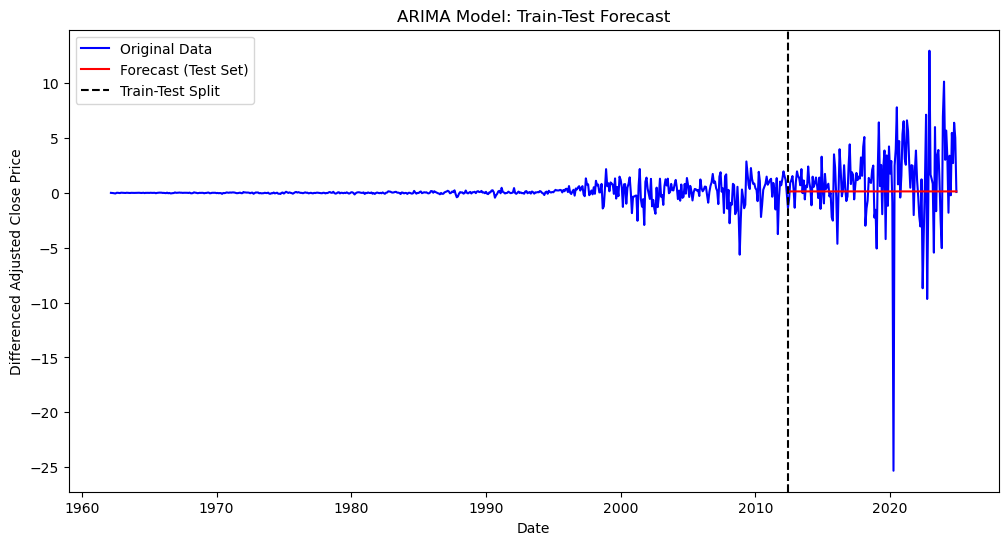

In [15]:
forecast = fitted_arima_model.forecast(steps=len(test_data))
plt.figure(figsize=(12, 6))
plt.plot(differenced_data, label="Original Data", color="blue")
plt.plot(test_data.index, forecast, label="Forecast (Test Set)", color="red")
plt.axvline(test_data.index[0], color='black', linestyle='--', label="Train-Test Split")
plt.title("ARIMA Model: Train-Test Forecast")
plt.xlabel("Date")
plt.ylabel("Differenced Adjusted Close Price")
plt.legend()
plt.show()



In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test_data, forecast)
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae, rmse

(2.5361325561441443, 3.8364957351168445)

In [17]:
# Optimize ARIMA model parameters (p, d, q) using AIC
import itertools

# Define parameter ranges
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Generate all combinations of (p, d, q)
pdq_combinations = list(itertools.product(p, d, q))

# Track the best model
best_aic = float('inf')
best_order = None
best_model = None

# Grid search through all combinations
for order in pdq_combinations:
    try:
        model = ARIMA(train_data, order=order)
        fitted_model = model.fit()
        if fitted_model.aic < best_aic:
            best_aic = fitted_model.aic
            best_order = order
            best_model = fitted_model
    except Exception:
        continue

# Display the best parameters and AIC score
best_order, best_aic


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

((2, 0, 2), 1139.8818893341468)

/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


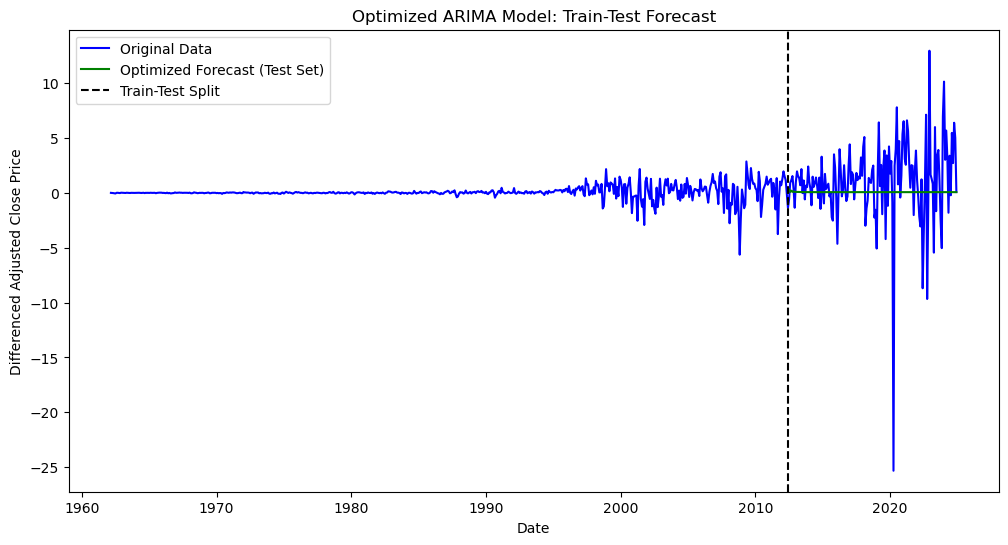

In [18]:
optimized_model = ARIMA(train_data, order=best_order)
fitted_optimized_model = optimized_model.fit()
optimized_forecast = fitted_optimized_model.forecast(steps=len(test_data))
plt.figure(figsize=(12, 6))
plt.plot(differenced_data, label="Original Data", color="blue")
plt.plot(test_data.index, optimized_forecast, label="Optimized Forecast (Test Set)", color="green")
plt.axvline(test_data.index[0], color='black', linestyle='--', label="Train-Test Split")
plt.title("Optimized ARIMA Model: Train-Test Forecast")
plt.xlabel("Date")
plt.ylabel("Differenced Adjusted Close Price")
plt.legend()
plt.show()

In [19]:
optimized_mae = mean_absolute_error(test_data, optimized_forecast)
optimized_rmse = np.sqrt(mean_squared_error(test_data, optimized_forecast))
optimized_mae, optimized_rmse

(2.561609923719235, 3.8533039240145963)

3. SARIMA

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

seasonal_order = (1, 1, 1, 12) 
sarima_model = SARIMAX(train_data, order=(2, 0, 2), seasonal_order=seasonal_order)
fitted_sarima_model = sarima_model.fit()
sarima_aic = fitted_sarima_model.aic


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08981D+00    |proj g|=  3.42721D-01

At iterate    5    f=  9.76990D-01    |proj g|=  1.54831D-01

At iterate   10    f=  9.56990D-01    |proj g|=  2.38138D-03

At iterate   15    f=  9.56946D-01    |proj g|=  2.62444D-03

At iterate   20    f=  9.56879D-01    |proj g|=  5.43497D-04

At iterate   25    f=  9.56879D-01    |proj g|=  2.22463D-04

At iterate   30    f=  9.56878D-01    |proj g|=  9.31692D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [22]:
P = range(0, 3)
D = range(0, 2)
Q = range(0, 3)
s = [12] 

# Generate all combinations of seasonal (P, D, Q, s)
seasonal_pdq_combinations = list(itertools.product(P, D, Q, s))

# Track the best SARIMA model
best_sarima_aic = float('inf')
best_sarima_order = None
best_sarima_seasonal_order = None
best_sarima_model = None

# Grid search through all combinations of SARIMA parameters
for seasonal_order in seasonal_pdq_combinations:
    try:
        model = SARIMAX(train_data, order=(2, 0, 2), seasonal_order=seasonal_order)
        fitted_model = model.fit()
        if fitted_model.aic < best_sarima_aic:
            best_sarima_aic = fitted_model.aic
            best_sarima_order = (2, 0, 2)
            best_sarima_seasonal_order = seasonal_order
            best_sarima_model = fitted_model
    except Exception:
        continue

# Return optimized SARIMA parameters and AIC score
{
    "Best SARIMA Order": best_sarima_order,
    "Best Seasonal Order": best_sarima_seasonal_order,
    "Best SARIMA AIC": best_sarima_aic,
}


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84849D-01    |proj g|=  2.65725D-01

At iterate    5    f=  9.49734D-01    |proj g|=  2.57898D-02

At iterate   10    f=  9.38367D-01    |proj g|=  1.53847D-02

At iterate   15    f=  9.37977D-01    |proj g|=  4.46655D-04

At iterate   20    f=  9.37954D-01    |proj g|=  4.84560D-04

At iterate   25    f=  9.37954D-01    |proj g|=  1.13818D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   

 This problem is unconstrained.


At iterate   15    f=  9.37749D-01    |proj g|=  2.16373D-04

At iterate   20    f=  9.37743D-01    |proj g|=  4.03037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     27      1     0     0   1.345D-06   9.377D-01
  F =  0.93774296831166437     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80450D-01    |proj g|=  2.66857D-01

At iterate    5    f=  9.42977D-01    |proj g|=  2.16047D-02


 This problem is unconstrained.



At iterate   10    f=  9.32463D-01    |proj g|=  2.28951D-02

At iterate   15    f=  9.31487D-01    |proj g|=  5.51003D-03

At iterate   20    f=  9.31241D-01    |proj g|=  1.08402D-03

At iterate   25    f=  9.31240D-01    |proj g|=  2.18863D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     30      1     0     0   2.189D-05   9.312D-01
  F =  0.93123953280311500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27655D+00    |proj g|=  2.87351D-01

At iterate    5    f=  1.23022D+00    |proj g|=  1.23562D-01

At iterate   10    f=  1.22499D+00    |proj g|=  2.51142D-03

At iterate   15    f=  1.22354D+00    |proj g|=  1.52549D-02

At iterate   20    f=  1.22073D+00    |proj g|=  3.61964D-03

At iterate   25    f=  1.21926D+00    |proj g|=  6.17253D-03

At iterate   30    f=  1.21459D+00    |proj g|=  4.78214D-03

At iterate   35    f=  1.21444D+00    |proj g|=  2.48445D-03

At iterate   40    f=  1.21443D+00    |proj g|=  1.14028D-04

At iterate   45    f=  1.21443D+00    |proj g|=  4.27424D-04

At iterate   50    f=  1.21442D+00    |proj g|=  3.69793D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07916D+00    |proj g|=  3.70383D-01


 This problem is unconstrained.



At iterate    5    f=  9.80137D-01    |proj g|=  5.54458D-02

At iterate   10    f=  9.57310D-01    |proj g|=  4.98616D-03

At iterate   15    f=  9.56996D-01    |proj g|=  5.01541D-03

At iterate   20    f=  9.56953D-01    |proj g|=  7.49326D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     28      1     0     0   4.290D-06   9.570D-01
  F =  0.95695260004004101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27655D+00    |proj g|=  4.48877D-01


 This problem is unconstrained.



At iterate    5    f=  9.93833D-01    |proj g|=  5.36668D-02

At iterate   10    f=  9.58276D-01    |proj g|=  9.10334D-03

At iterate   15    f=  9.56872D-01    |proj g|=  1.36144D-03

At iterate   20    f=  9.56852D-01    |proj g|=  3.15121D-04

At iterate   25    f=  9.56848D-01    |proj g|=  4.81886D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     33      1     0     0   9.477D-06   9.568D-01
  F =  0.95684658730239436     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84637D-01    |proj g|=  2.66049D-01

At iterate    5    f=  9.49429D-01    |proj g|=  2.53881D-02

At iterate   10    f=  9.38305D-01    |proj g|=  1.62424D-02

At iterate   15    f=  9.37807D-01    |proj g|=  2.62157D-04

At iterate   20    f=  9.37798D-01    |proj g|=  1.29906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     28      1     0     0   1.205D-05   9.378D-01
  F =  0.93779660226932648     

CONVERG

/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84234D-01    |proj g|=  2.66718D-01

At iterate    5    f=  9.48742D-01    |proj g|=  2.49525D-02

At iterate   10    f=  9.37605D-01    |proj g|=  2.21997D-02

At iterate   15    f=  9.36919D-01    |proj g|=  1.88196D-03

At iterate   20    f=  9.36685D-01    |proj g|=  9.32929D-03

At iterate   25    f=  9.36658D-01    |proj g|=  1.79644D-04

At iterate   30    f=  9.36655D-01    |proj g|=  1.26978D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80257D-01    |proj g|=  2.67029D-01

At iterate    5    f=  9.42759D-01    |proj g|=  2.16108D-02


 This problem is unconstrained.



At iterate   10    f=  9.32325D-01    |proj g|=  3.05501D-02

At iterate   15    f=  9.31044D-01    |proj g|=  1.92440D-03

At iterate   20    f=  9.30796D-01    |proj g|=  5.17385D-03

At iterate   25    f=  9.30760D-01    |proj g|=  1.14483D-03

At iterate   30    f=  9.30744D-01    |proj g|=  6.20627D-04

At iterate   35    f=  9.30743D-01    |proj g|=  1.35562D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     40      1     0     0   1.356D-05   9.307D-01
  F =  0.93074270997019592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17819D+00    |proj g|=  2.14251D-01

At iterate    5    f=  1.14228D+00    |proj g|=  3.76969D-02

At iterate   10    f=  1.13290D+00    |proj g|=  7.09098D-03

At iterate   15    f=  1.13251D+00    |proj g|=  9.02246D-03

At iterate   20    f=  1.13037D+00    |proj g|=  2.46787D-02

At iterate   25    f=  1.12703D+00    |proj g|=  2.06813D-02

At iterate   30    f=  1.12293D+00    |proj g|=  5.11931D-03

At iterate   35    f=  1.12273D+00    |proj g|=  2.63869D-03

At iterate   40    f=  1.12264D+00    |proj g|=  9.18723D-04

At iterate   45    f=  1.12262D+00    |proj g|=  6.81589D-04


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



At iterate   50    f=  1.12262D+00    |proj g|=  2.00648D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   2.006D-04   1.123D+00
  F =   1.1226234540494520     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08981D+00    |proj g|=  3.42721D-01

At iterate    5    f=  9.76990D-01    |proj g|=  1.54831D-01

At iterate   10    f=  9.56990D-01    |proj g|=  2.38138D-03

At iterate   15    f=  9.56946D-01    |proj g|=  2.62444D-03

At iterate   20    f=  9.56879D-01    |proj g|=  5.43497D-04

At iterate   25    f=  9.56879D-01    |proj g|=  2.22463D-04

At iterate   30    f=  9.56878D-01    |proj g|=  9.31692D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05574D+00    |proj g|=  4.56904D-01


 This problem is unconstrained.



At iterate    5    f=  9.68675D-01    |proj g|=  1.32041D-02

At iterate   10    f=  9.60354D-01    |proj g|=  6.50558D-02

At iterate   15    f=  9.56681D-01    |proj g|=  1.00988D-03

At iterate   20    f=  9.56525D-01    |proj g|=  6.78679D-03

At iterate   25    f=  9.56357D-01    |proj g|=  1.52697D-03

At iterate   30    f=  9.56211D-01    |proj g|=  2.47860D-03

At iterate   35    f=  9.55853D-01    |proj g|=  5.40397D-03

At iterate   40    f=  9.55818D-01    |proj g|=  3.37073D-04

At iterate   45    f=  9.55816D-01    |proj g|=  5.48956D-04


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.55812D-01    |proj g|=  6.33595D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   6.336D-05   9.558D-01
  F =  0.95581249390324563     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78502D-01    |proj g|=  2.66352D-01

At iterate    5    f=  9.41611D-01    |proj g|=  2.04348D-02

At iterate   10    f=  9.31504D-01    |proj g|=  2.52262D-02

At iterate   15    f=  9.30633D-01    |proj g|=  3.10068D-03

At iterate   20    f=  9.30285D-01    |proj g|=  5.07214D-03

At iterate   25    f=  9.30271D-01    |proj g|=  2.38383D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     30      1     0     0   

/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79848D-01    |proj g|=  2.67061D-01

At iterate    5    f=  9.42538D-01    |proj g|=  2.19004D-02

At iterate   10    f=  9.31870D-01    |proj g|=  3.19921D-02

At iterate   15    f=  9.30390D-01    |proj g|=  2.00141D-03

At iterate   20    f=  9.30058D-01    |proj g|=  8.64385D-03

At iterate   25    f=  9.30016D-01    |proj g|=  1.75862D-03

At iterate   30    f=  9.29990D-01    |proj g|=  2.58005D-04

At iterate   35    f=  9.29990D-01    |proj g|=  9.68656D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79653D-01    |proj g|=  2.66942D-01

At iterate    5    f=  9.42226D-01    |proj g|=  2.08064D-02


 This problem is unconstrained.



At iterate   10    f=  9.30835D-01    |proj g|=  1.87530D-02

At iterate   15    f=  9.30086D-01    |proj g|=  1.92692D-03

At iterate   20    f=  9.29872D-01    |proj g|=  2.02185D-02

At iterate   25    f=  9.29743D-01    |proj g|=  1.11041D-03

At iterate   30    f=  9.29737D-01    |proj g|=  2.09580D-04

At iterate   35    f=  9.29732D-01    |proj g|=  2.00079D-03

At iterate   40    f=  9.29729D-01    |proj g|=  1.54990D-03

At iterate   45    f=  9.29697D-01    |proj g|=  1.03760D-03


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  9.29689D-01    |proj g|=  3.49017D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     56      1     0     0   3.490D-04   9.297D-01
  F =  0.92968899559818163     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12722D+00    |proj g|=  2.52286D-01

At iterate    5    f=  1.08358D+00    |proj g|=  1.74800D-02

At iterate   10    f=  1.07312D+00    |proj g|=  1.17695D-02

At iter

/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10203D+00    |proj g|=  3.14590D-01


 This problem is unconstrained.



At iterate    5    f=  1.00573D+00    |proj g|=  1.74017D-01

At iterate   10    f=  9.48276D-01    |proj g|=  3.15581D-02

At iterate   15    f=  9.47706D-01    |proj g|=  1.47958D-03

At iterate   20    f=  9.47497D-01    |proj g|=  8.08181D-03

At iterate   25    f=  9.47457D-01    |proj g|=  6.50136D-04

At iterate   30    f=  9.47452D-01    |proj g|=  2.61099D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     35      1     0     0   7.125D-06   9.475D-01
  F =  0.94745177952542592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06098D+00    |proj g|=  4.28818D-01

At iterate    5    f=  9.76773D-01    |proj g|=  8.30668D-02

At iterate   10    f=  9.58377D-01    |proj g|=  1.28706D-02

At iterate   15    f=  9.56982D-01    |proj g|=  6.53617D-04

At iterate   20    f=  9.56940D-01    |proj g|=  3.71703D-03

At iterate   25    f=  9.56898D-01    |proj g|=  1.85546D-03

At iterate   30    f=  9.56092D-01    |proj g|=  2.13688D-02

At iterate   35    f=  9.55364D-01    |proj g|=  2.01861D-02

At iterate   40    f=  9.51973D-01    |proj g|=  1.15535D-02

At iterate   45    f=  9.47484D-01    |proj g|=  1.54349D-02


/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.45354D-01    |proj g|=  6.72044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   6.720D-03   9.454D-01
  F =  0.94535356477310994     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


{'Best SARIMA Order': (2, 0, 2),
 'Best Seasonal Order': (2, 0, 0, 12),
 'Best SARIMA AIC': 1135.9064647543728}

SARIMA has lower AIC score hence it's a better fit.

/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/khoavan/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78502D-01    |proj g|=  2.66352D-01

At iterate    5    f=  9.41611D-01    |proj g|=  2.04348D-02

At iterate   10    f=  9.31504D-01    |proj g|=  2.52262D-02

At iterate   15    f=  9.30633D-01    |proj g|=  3.10068D-03

At iterate   20    f=  9.30285D-01    |proj g|=  5.07214D-03

At iterate   25    f=  9.30271D-01    |proj g|=  2.38383D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     30      1     0     0   

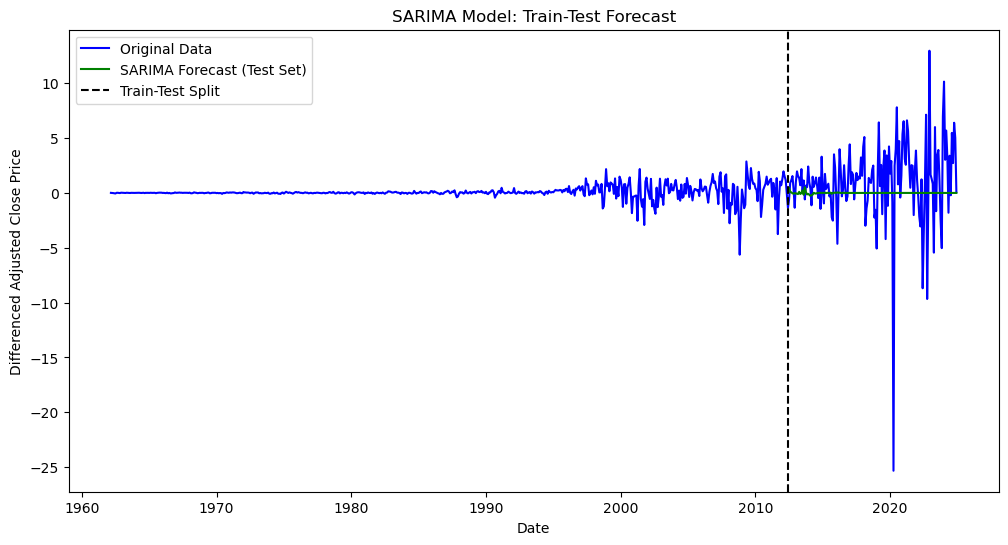

In [23]:
final_sarima_model = SARIMAX(train_data, order=(2, 0, 2), seasonal_order=(2, 0, 0, 12))
fitted_final_sarima = final_sarima_model.fit()
sarima_forecast = fitted_final_sarima.forecast(steps=len(test_data))
plt.figure(figsize=(12, 6))
plt.plot(differenced_data, label="Original Data", color="blue")
plt.plot(test_data.index, sarima_forecast, label="SARIMA Forecast (Test Set)", color="green")
plt.axvline(test_data.index[0], color='black', linestyle='--', label="Train-Test Split")
plt.title("SARIMA Model: Train-Test Forecast")
plt.xlabel("Date")
plt.ylabel("Differenced Adjusted Close Price")
plt.legend()
plt.show()

In [24]:
sarima_mae = mean_absolute_error(test_data, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_forecast))
sarima_mae, sarima_rmse

(2.6066996322563507, 3.8768912364670602)

Performance on test data is worse since scores are higher.

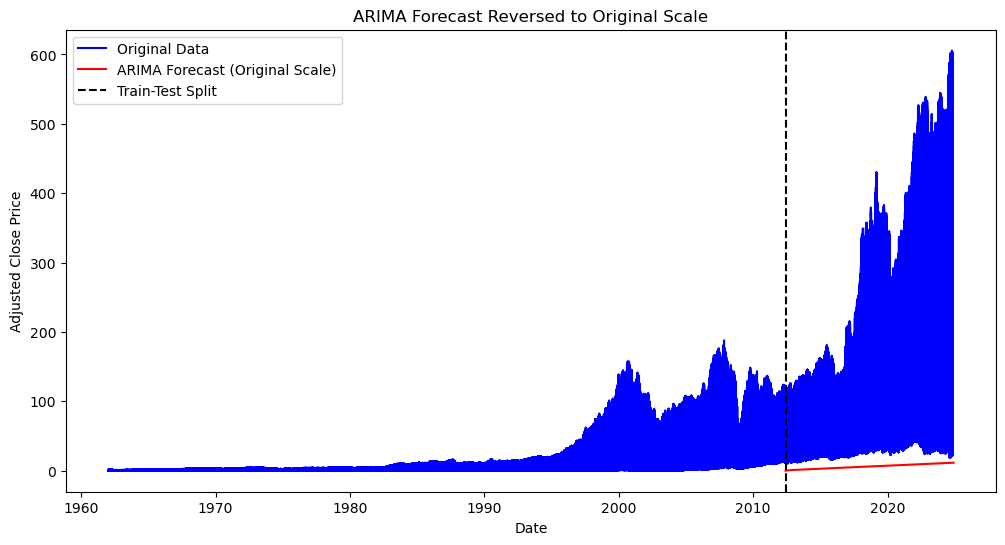

In [25]:
arima_forecast_reversed = pd.Series(fitted_optimized_model.forecast(steps=len(test_data)))
arima_forecast_original = arima_forecast_reversed.cumsum() + train_data.iloc[-1]
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Adj Close'], label="Original Data", color="blue")
plt.plot(test_data.index, arima_forecast_original, label="ARIMA Forecast (Original Scale)", color="red")
plt.axvline(test_data.index[0], color='black', linestyle='--', label="Train-Test Split")
plt.title("ARIMA Forecast Reversed to Original Scale")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.show()

In [34]:
numeric_df = df.select_dtypes(include=['number'])  
df_monthly = numeric_df.resample('M').mean()
common_index = test_data.index.intersection(df_monthly.index)
df_monthly = df_monthly.loc[common_index]
test_data = test_data.loc[common_index]
arima_mae_original = mean_absolute_error(df_monthly['Adj Close'], arima_forecast_original)
arima_rmse_original = np.sqrt(mean_squared_error(df_monthly['Adj Close'], arima_forecast_original))

arima_mae_original, arima_rmse_original


(98.48820421317203, 106.4121893686242)